In [ ]:
# transformer
!pip install -q -U datasets gdown transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import tensorflow as tf
import random # for seed value
import string
import pandas as pd
%matplotlib inline
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# metrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# transformer
# from transformers import AutoImageProcessor, ResNetModel
import torch

# 1- Import dataset

In [ ]:
test = pd.read_csv('./sign_mnist_test.csv')
train = pd.read_csv('./sign_mnist_train.csv')

In [ ]:
print("Shape of train_data: ",train.shape,"Shape of test_data: ",test.shape)

Shape of train_data:  (27455, 785) Shape of test_data:  (7172, 785)


In [ ]:
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
strlabels=list(string.ascii_uppercase) # Appending alphabet to a list.
print(strlabels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
len(strlabels)

26

# 2- Train Test Split

In [ ]:
#train
train_labels=train["label"]
train_images=train.drop("label",axis=1).values
#test
test_labels=test["label"]
test_images=test.drop("label",axis=1).values

train_images=train_images/255.0
test_images=test_images/255.0

train_images=train_images.reshape(-1,28,28,1)
test_images=test_images.reshape(-1,28,28,1)
print(train_images.shape)

(27455, 28, 28, 1)


# 3- Show images with labels

<Figure size 1500x500 with 0 Axes>

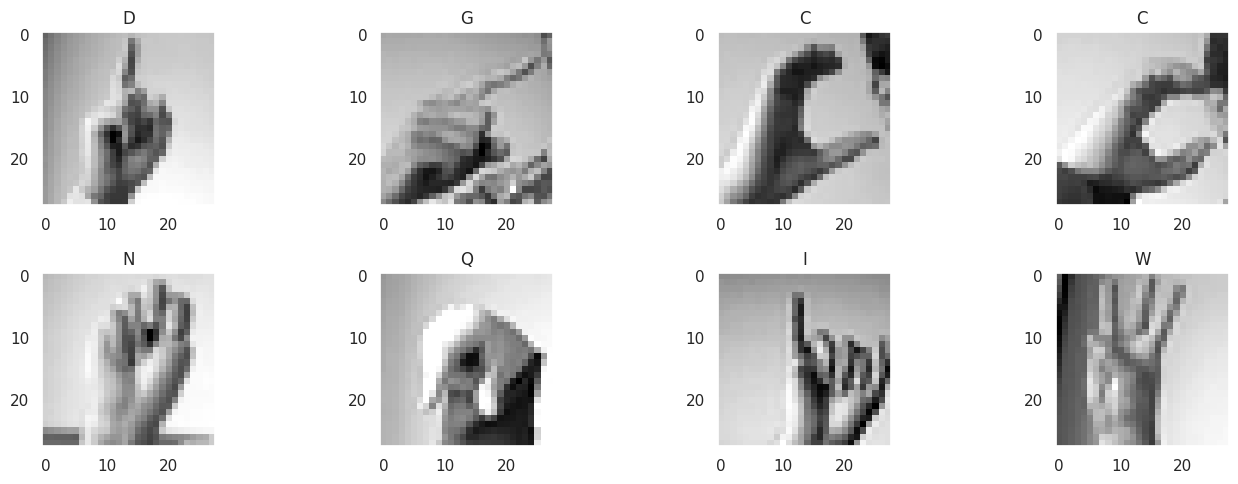

In [ ]:
selected_image=train_images[:10]
selected_label=train_labels[:10]
plt.figure()
f, graph = plt.subplots(2,4)
f.set_size_inches(14, 5)
z=0
for i in range(2):
    for k in range(4):
        graph[i][k].imshow(selected_image[z].reshape(28,28),cmap="gray")
        graph[i][k].grid(False)
        graph[i][k].set_title(strlabels[selected_label[z]] )
        z+=1
plt.tight_layout()
plt.show()

# 4- Build CNN model and train model

## Data Augmentation

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False ,
    vertical_flip=False)

generator.fit(train_images)

## Calback

In [ ]:
acc_treshold = 1.0
class myCallback(tf.keras.callbacks.Callback):
    epc=0
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') >= acc_treshold-0.0100 and logs.get('val_acc') >= acc_treshold):
            print("\nReached %2.2f%% accuracy !" %(logs.get('val_acc')*100))
            self.model.stop_training = True
            self.epc=epoch+1
callbacks = myCallback()

## Building CNN Model

In [ ]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu",input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25,activation="softmax")
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),loss="sparse_categorical_crossentropy",metrics=["acc"])
model.summary()
epochs=80
history=model.fit(generator.flow(train_images,train_labels,batch_size=128),epochs=epochs,callbacks=[callbacks],validation_data=(test_images,test_labels),verbose=1)

test_loss,test_acc=model.evaluate(test_images,test_labels)
print("test acc:",test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)      

## Prediction for test

In [ ]:
prediction=model.predict(test_images)

225/225 [==============================] - 5s 21ms/step


In [ ]:
predictions=[]
test_labels_string=[]
for i in range(0,test_labels.size):
    predictions.append(strlabels[np.argmax(prediction[i])]) # np.argmax() for taking highest value among the others.
    test_labels_string.append(strlabels[test_labels[i]])
# Converting predictions to letters.

In [ ]:
print(predictions)

['G', 'F', 'K', 'A', 'D', 'V', 'K', 'O', 'D', 'H', 'I', 'I', 'V', 'M', 'H', 'E', 'W', 'A', 'H', 'H', 'C', 'A', 'V', 'E', 'K', 'P', 'C', 'P', 'H', 'B', 'H', 'I', 'N', 'T', 'D', 'V', 'N', 'D', 'S', 'O', 'P', 'X', 'I', 'P', 'O', 'F', 'R', 'E', 'T', 'N', 'U', 'W', 'U', 'F', 'Q', 'Q', 'V', 'E', 'H', 'W', 'K', 'N', 'L', 'W', 'C', 'K', 'B', 'E', 'S', 'E', 'U', 'G', 'P', 'E', 'D', 'U', 'P', 'L', 'C', 'C', 'R', 'C', 'H', 'V', 'X', 'H', 'M', 'R', 'Y', 'O', 'C', 'B', 'H', 'X', 'I', 'F', 'A', 'A', 'T', 'V', 'I', 'E', 'C', 'U', 'Q', 'B', 'P', 'O', 'C', 'G', 'M', 'F', 'A', 'Y', 'C', 'T', 'O', 'Y', 'Q', 'K', 'E', 'I', 'I', 'M', 'M', 'I', 'G', 'V', 'E', 'P', 'L', 'V', 'C', 'P', 'X', 'X', 'E', 'V', 'W', 'D', 'P', 'S', 'H', 'R', 'V', 'G', 'B', 'G', 'K', 'F', 'E', 'V', 'D', 'V', 'O', 'X', 'C', 'K', 'H', 'F', 'O', 'V', 'I', 'E', 'S', 'X', 'N', 'D', 'G', 'I', 'N', 'P', 'E', 'Q', 'D', 'R', 'S', 'G', 'V', 'B', 'N', 'Q', 'Y', 'X', 'C', 'H', 'I', 'Y', 'B', 'M', 'X', 'D', 'A', 'P', 'N', 'P', 'N', 'F', 'L', 'B',

## Visualizing accuracy

<Figure size 1500x500 with 0 Axes>

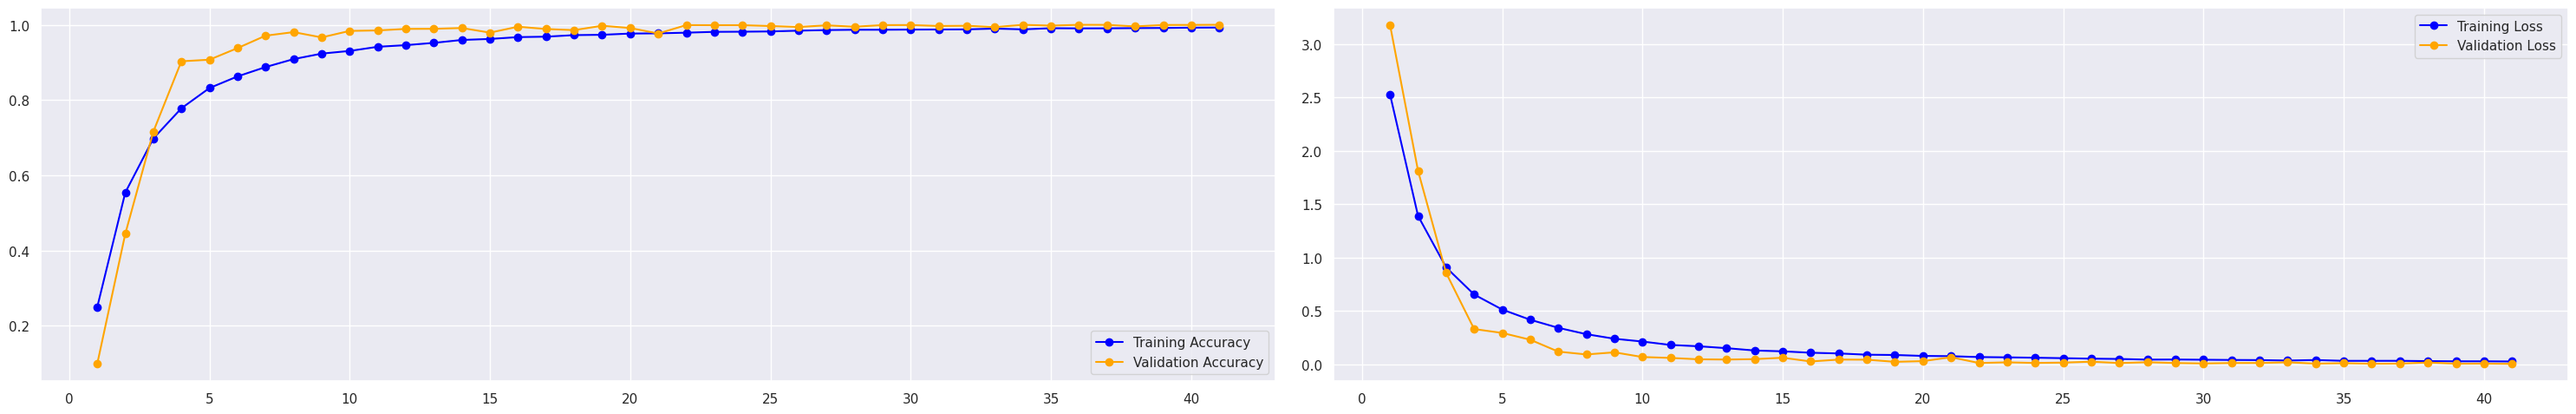

In [ ]:
epoch_range=range(1,callbacks.epc+1 if callbacks.epc != 0 else epochs) # Epoch range for plotting our x-axis.
plt.figure() # Matplotlib for visualization.
fig, ax = plt.subplots(1,2) # Making space for 2 rows and 4 images for each row.
fig.set_size_inches(30, 5) # Size of images.
plt.tight_layout() # Wide space for images.
ax[0].plot(epoch_range,history.history["acc"],color="blue",marker="o")
ax[0].plot(epoch_range,history.history["val_acc"],color="orange",marker="o")
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
ax[1].plot(epoch_range,np.array(history.history["loss"]),color="blue",marker="o")
ax[1].plot(epoch_range,np.array(history.history["val_loss"]),color="orange",marker="o")
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# 5-Confusion Matrix for Checking Results

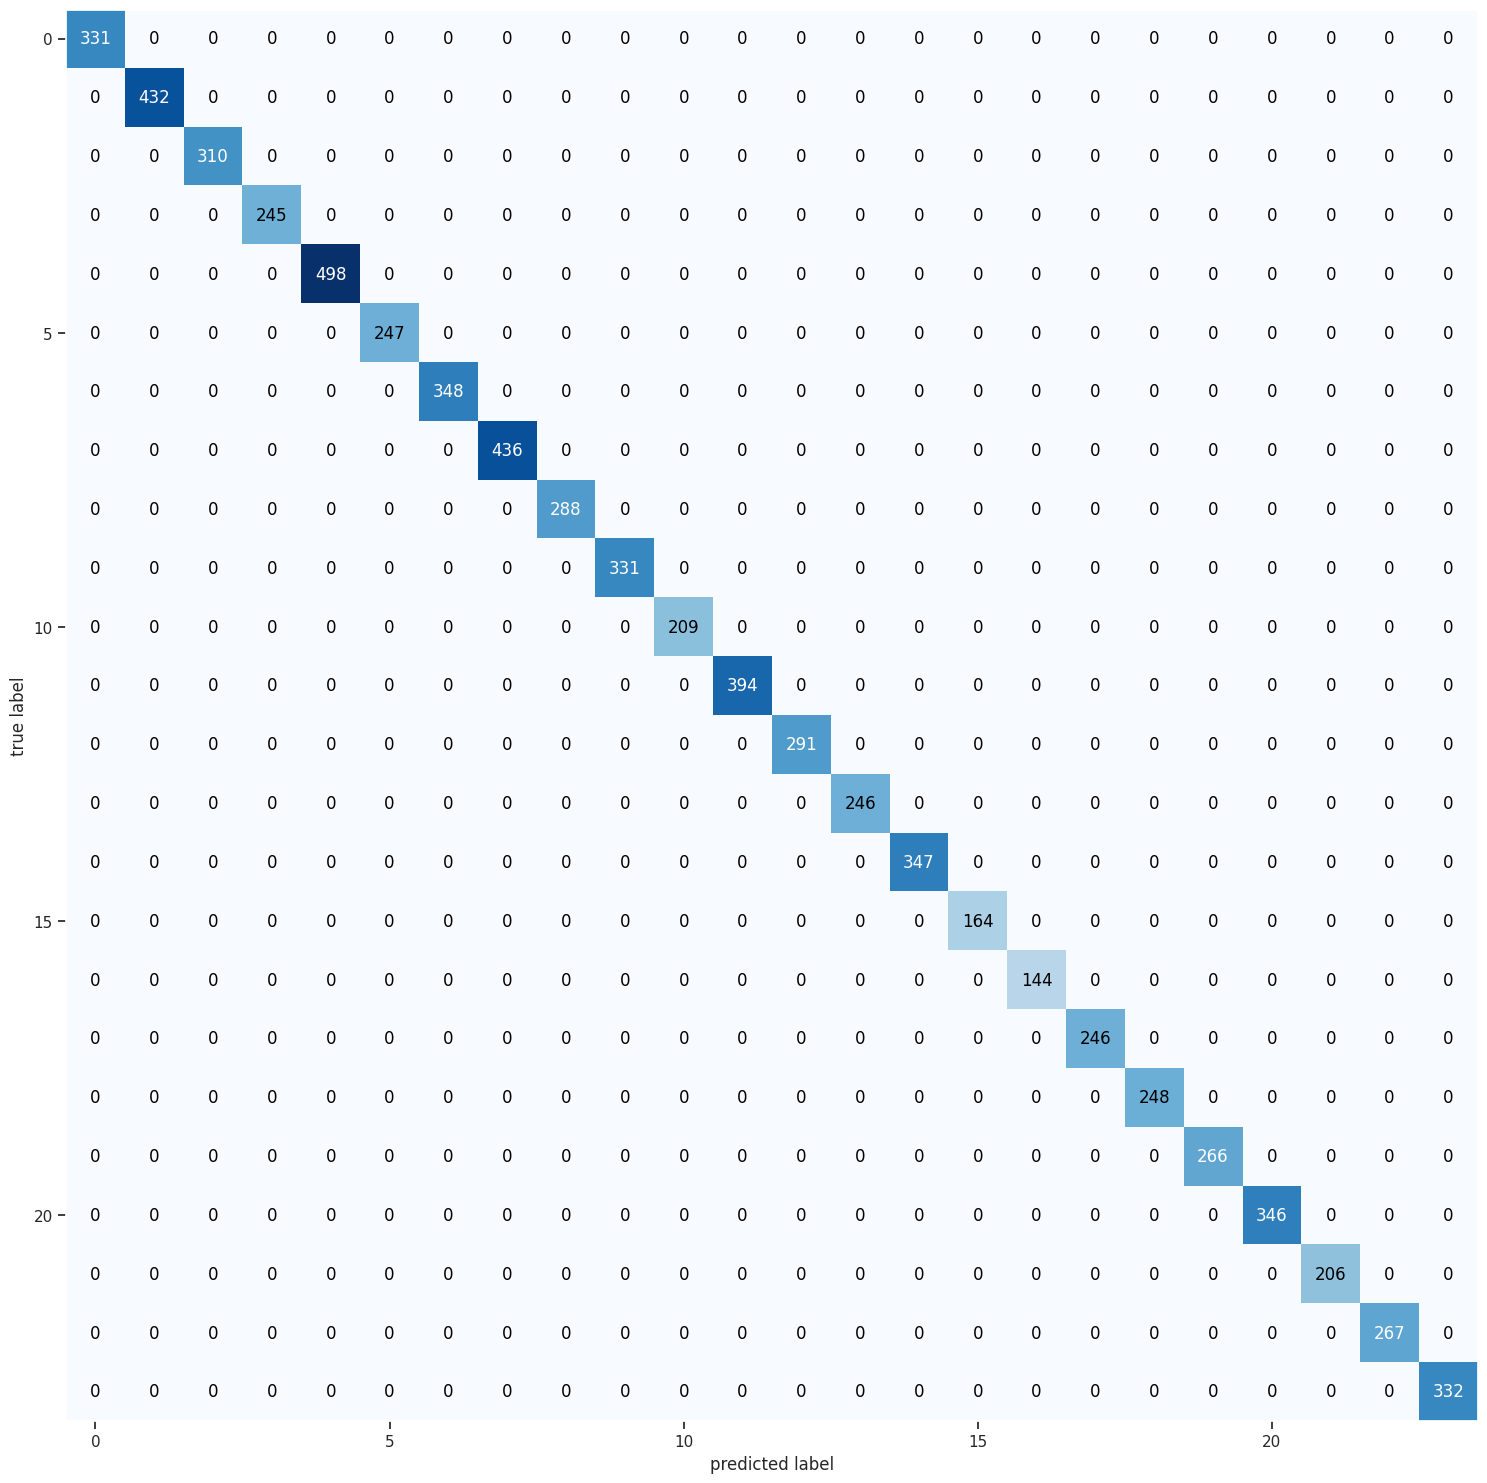

In [ ]:
cf=confusion_matrix(predictions,test_labels_string)
fig, ax = plot_confusion_matrix(conf_mat=cf)
fig.set_size_inches(15, 15) # Size of image.
plt.tight_layout() # Wide space for image.
plt.show()

# 6- Compare Predict and Testing label of image

Predicted letter is: K 
True Answer: K


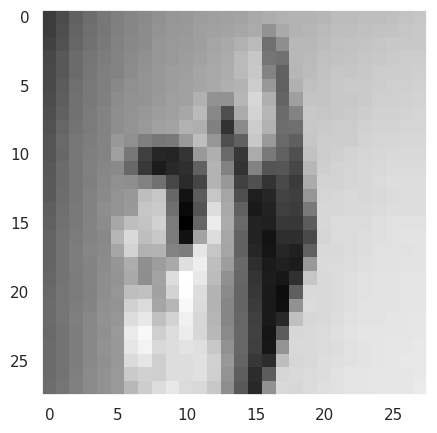

In [ ]:
n=6
plt.imshow(test_images[n].reshape(28,28),cmap="gray")
plt.grid(False)
print("Predicted letter is:",predictions[n],"\nTrue Answer:",test_labels_string[n])

#7- Use ResNet-50

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/My Drive/mnist"

/content/gdrive/My Drive/mnist


In [ ]:
%ls

Test/  Train/  Val/


In [2]:
from tensorflow.keras.layers import Conv2D ,Flatten , Dense, MaxPool2D  , GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input , decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.models import Sequential, Model
import tensorflow as tf
#
import pandas as pd
import seaborn as sn

In [4]:
img_width, img_height = 224, 224
batch_size=32

train_data_dir = '/content/gdrive/My Drive/mnist/Train/'
test_data_dir = '/content/gdrive/My Drive/mnist/Test/'
validation_data_dir = '/content/gdrive/My Drive/mnist/Val/'


train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode="categorical",
      shuffle="training")

valid_generator = train_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_width, img_height),
      batch_size=batch_size,
      class_mode="categorical",
      shuffle="validation")


Found 26076 images belonging to 24 classes.
Found 3600 images belonging to 24 classes.


In [5]:
test_generator = train_datagen.flow_from_directory(
      test_data_dir,
      target_size=(img_width, img_height),
      batch_size=1,
      class_mode="categorical",
      shuffle="test")

Found 3612 images belonging to 24 classes.


In [6]:
x,y=test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
base_model=ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
  layer.trainable=False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_generator,epochs=1)

815/815 [==============================] - 9205s 11s/step - loss: 0.4903 - accuracy: 0.8423


In [ ]:
model.save('/content/gdrive/My Drive/mnist/ResNet50_mnist.h5/')

In [ ]:
test_loss , test_acc = model.evaluate(test_generator,verbose=2)
print("test accuracy",test_acc)

3612/3612 - 1279s - loss: 0.4772 - accuracy: 0.8333 - 1279s/epoch - 354ms/step
test accuracy 0.8333333134651184


1/1 [==============================] - 0s 411ms/step


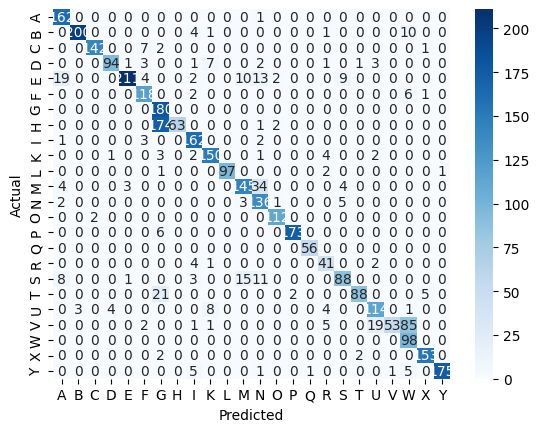

In [7]:
model=tf.keras.models.load_model('/content/gdrive/My Drive/mnist/ResNet50_mnist.h5/')

filenames=test_generator.filenames
nb_samples=len(test_generator)

y_prob=[]
y_act=[]
test_generator.reset()

for _ in range(nb_samples):
  X_test,Y_test=test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df=pd.DataFrame(np.vstack([predicted_class,actual_class]).T , columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'] ,rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues' ,annot=True , fmt='d')
plt.show()